<b><font size="6">Techscape Project</font><a class="anchor"><a id='toc'></a></b><br>

# Import the needed libraries

In [49]:
import pandas as pd
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import calendar

import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

# Import data

In [2]:
techscape = pd.read_csv('train.csv')

print(techscape.shape)
techscape.head(3)

(9999, 17)


,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,21-Mar-20,0,0.0,0,0.0,3,64.0,0.0000,0.0667,0.0,MacOSX,2,Portugal,1,Returner,0
1,103117814,20-May-20,0,0.0,0,0.0,23,684.5,0.0217,0.0449,0.0,Windows,2,France,6,Returner,0
2,103201891,4-Dec-20,0,0.0,0,0.0,8,95.0,0.0250,0.0583,0.0,Windows,4,Italy,1,Returner,0


# Check for missing data

In [3]:
techscape.info()
# There are now missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Access_ID                   9999 non-null   int64  
 1   Date                        9999 non-null   object 
 2   AccountMng_Pages            9999 non-null   int64  
 3   AccountMng_Duration         9999 non-null   float64
 4   FAQ_Pages                   9999 non-null   int64  
 5   FAQ_Duration                9999 non-null   float64
 6   Product_Pages               9999 non-null   int64  
 7   Product_Duration            9999 non-null   float64
 8   GoogleAnalytics_BounceRate  9999 non-null   float64
 9   GoogleAnalytics_ExitRate    9999 non-null   float64
 10  GoogleAnalytics_PageValue   9999 non-null   float64
 11  OS                          9999 non-null   object 
 12  Browser                     9999 non-null   int64  
 13  Country                     9999 

# Change the types of the variables

In [4]:
# ID does not make sense to be a int
techscape.Access_ID = techscape.Access_ID.astype('string') 

# Tranform Date into a datetime format
techscape.Date = pd.to_datetime(techscape.Date)

techscape.OS = techscape.OS.astype('string') 

techscape.Country = techscape.Country.astype('string') 

techscape.Type_of_Visitor = techscape.Type_of_Visitor.astype('string') 

techscape.Type_of_Traffic = techscape.Type_of_Traffic.astype('string') 

techscape.Browser = techscape.Browser.astype('string') 

#techscape.info()

# Check for incoherencies in the data


In [5]:
# Date variable
print(f'Date of the web visit varies from {techscape.Date.min()} and {techscape.Date.max()}, excluding the month of April.')

Date of the web visit varies from 2020-02-01 00:00:00 and 2020-12-31 00:00:00, excluding the month of April.


In [6]:
# Incoherencies between Pages and Duration variables

# usually, it doesn´t make sense that Pages > 0 and Duration = 0. However, there are too many observations like that,
# so, instead of removing them, we decided to convert (duration = 0, pages=1)  --> (duration = 1, pages=1)

#techscape[(techscape['AccountMng_Pages']==0) & (techscape['AccountMng_Duration']!=0) ] # --> 0
account_index = techscape[(techscape['AccountMng_Pages']>1) & (techscape['AccountMng_Duration']==0) ].index  # --> 3
len(account_index)
techscape.loc[techscape['AccountMng_Duration']==0,'AccountMng_Duration'] = 1

#techscape[(techscape['FAQ_Pages']==0) & (techscape['FAQ_Duration']!=0) ] # --> 0
faq_index = techscape[(techscape['FAQ_Pages']>1) & (techscape['FAQ_Duration']==0) ].index # --> 9
len(faq_index)
techscape.loc[techscape['FAQ_Duration']==0,'FAQ_Duration'] = 1

#techscape[(techscape['Product_Pages']==0) & (techscape['Product_Duration']!=0) ] # --> 0
product_index = techscape[(techscape['Product_Pages']>1) & (techscape['Product_Duration']==0) ].index # --> 130
len(product_index)
techscape.loc[techscape['Product_Duration']==0,'Product_Duration'] = 1

techscape.shape
# Total rectified = 3 + 9 + 130 = 142 (1.42%)

(9999, 17)

# Deal with the outliers

In [7]:
# Se descriptive statistics for all the variables
techscape.describe().T

,count,mean,std,min,25%,50%,75%,max
AccountMng_Pages,9999.0,2.324232,3.340676,0.0,0.0000,1.0000,4.00000,27.0000
AccountMng_Duration,9999.0,81.684402,179.499853,1.0,1.0000,7.5000,92.20835,3398.7500
FAQ_Pages,9999.0,0.508051,1.279390,0.0,0.0000,0.0000,0.00000,24.0000
FAQ_Duration,9999.0,35.362182,139.598866,1.0,1.0000,1.0000,1.00000,2549.3750
Product_Pages,9999.0,31.685869,44.550277,0.0,7.0000,18.0000,38.00000,705.0000
Product_Duration,9999.0,1199.832236,1958.237836,0.5,183.5625,599.0000,1470.27080,63973.5222
GoogleAnalytics_BounceRate,9999.0,0.022305,0.048776,0.0,0.0000,0.0032,0.01680,0.2000
GoogleAnalytics_ExitRate,9999.0,0.043181,0.048845,0.0,0.0143,0.0251,0.05000,0.2000
GoogleAnalytics_PageValue,9999.0,5.963120,18.753626,0.0,0.0000,0.0000,0.00000,361.7637
Buy,9999.0,0.155216,0.362128,0.0,0.0000,0.0000,0.00000,1.0000


In [8]:
# Separate the metric variables from the non metric ones to plot the following graphics
metric_features = techscape.select_dtypes(include=np.number).set_index(techscape.index).columns.to_list()
non_metric_features = techscape.select_dtypes(exclude=np.number).set_index(techscape.index).columns.to_list()

### Plot the histograms of the numeric variables

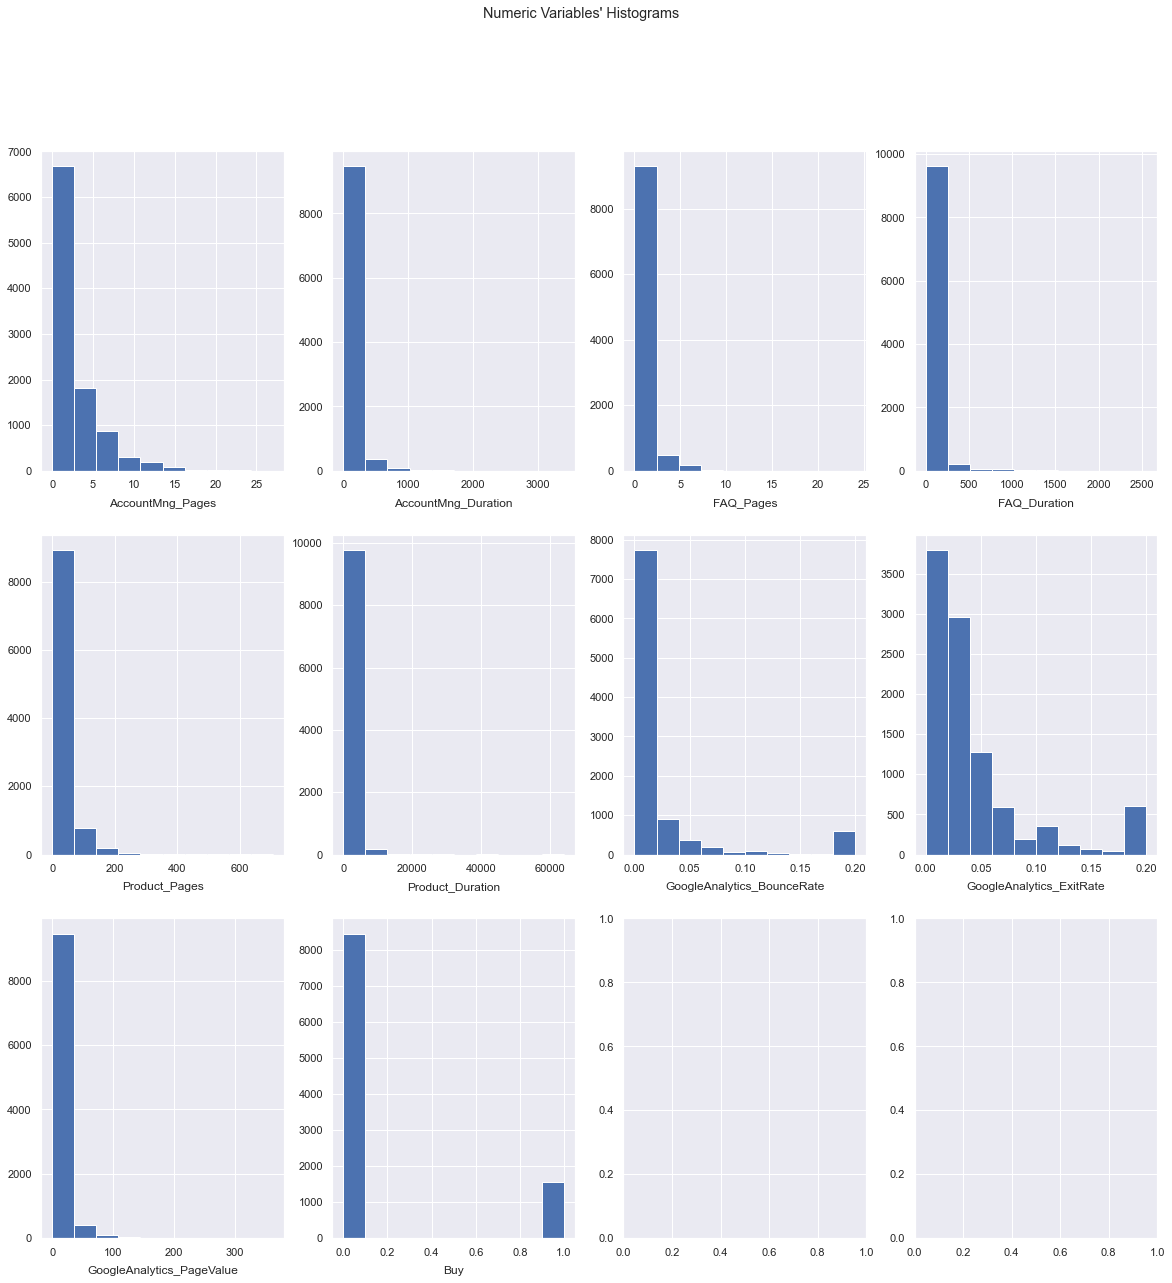

In [9]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, math.ceil(len(metric_features) / 3), figsize=(20,20))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(techscape[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

### Plot the boxplots of the numeric variables

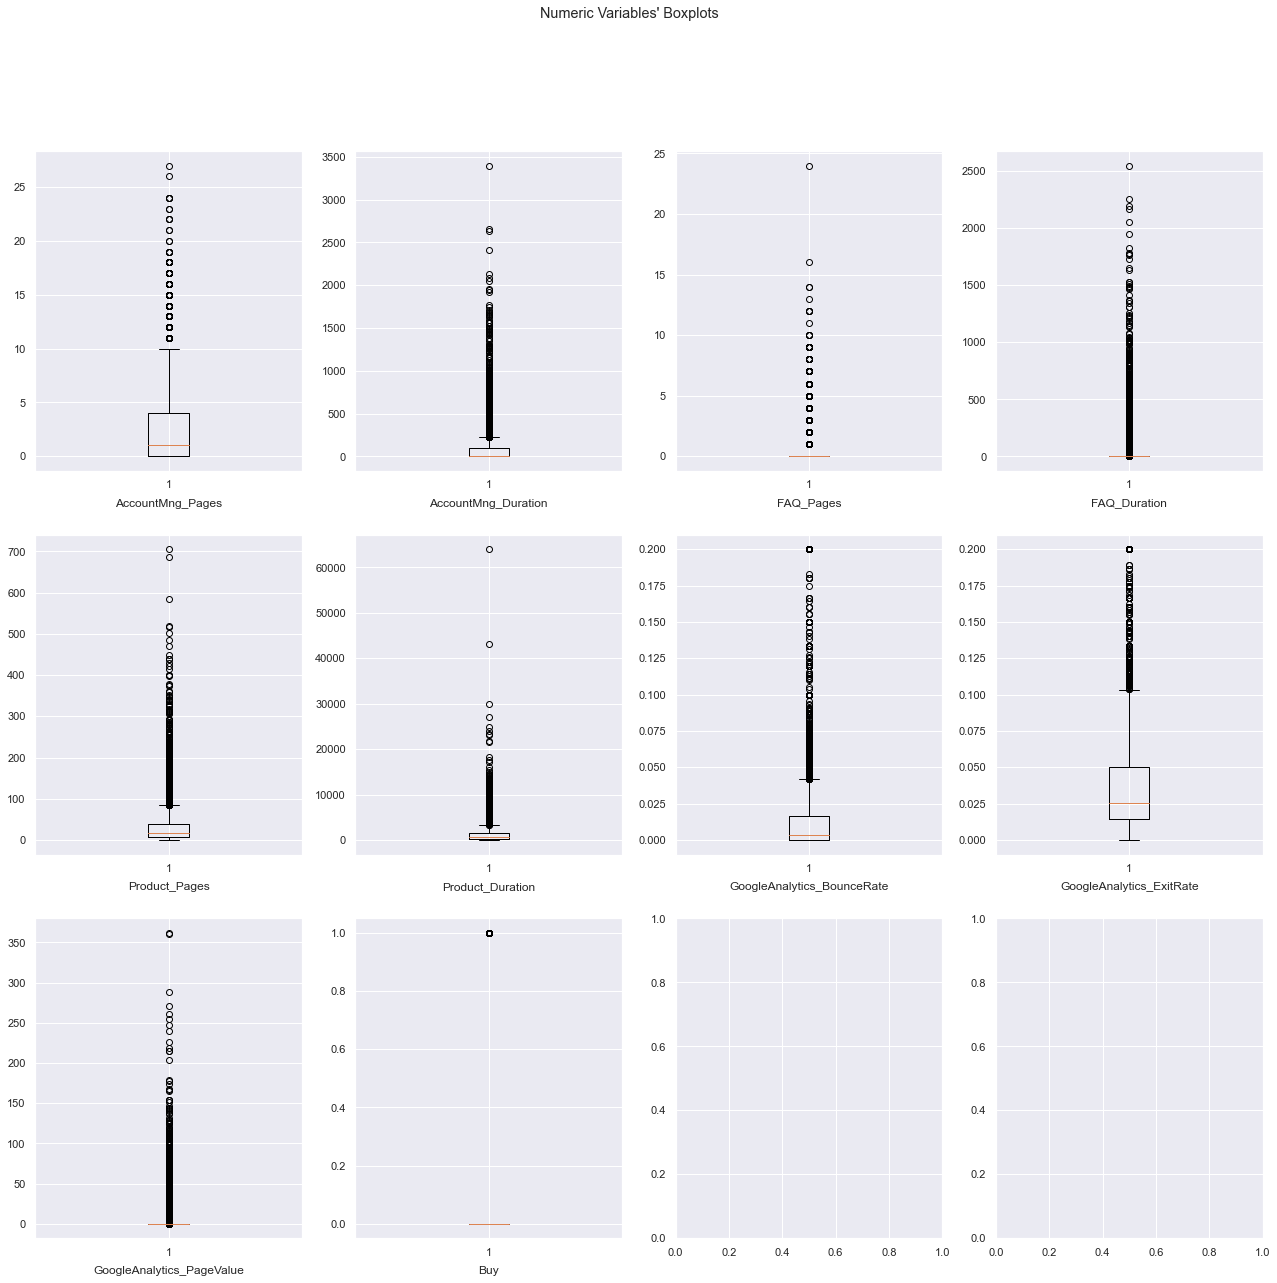

In [10]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, math.ceil(len(metric_features) / 3), figsize=(22, 20))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.boxplot(techscape[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Boxplots"

plt.suptitle(title)

plt.show()

### Filter 1 to remove outliers - Manually

In [11]:
# This may vary from session to session, and is prone to varying interpretations.
# A simple example is provided below:

filters1 = (
    (techscape['AccountMng_Pages']<= 10)  
    &
    (techscape['AccountMng_Duration']<= 1000)
    &
    (techscape['FAQ_Pages']<=7)
    &
    (techscape['FAQ_Duration']<=700)
    &
    (techscape['Product_Pages']<=350)
    &
    (techscape['Product_Duration']<=20000)
    &
    (techscape['GoogleAnalytics_BounceRate']<= 0.1)
    &
    (techscape['GoogleAnalytics_ExitRate']<= 0.13)
    &
    (techscape['GoogleAnalytics_PageValue']<= 100)   
)

techscape_1 = techscape[filters1]

perc_outliers1 = np.round((techscape.shape[0] - techscape_1.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of observations removed: {perc_outliers1}%')

Percentage of observations removed: 13.22%


### Filter 2 to remove outliers - Interquantile Method

In [12]:
techscape_mean, techscape_std = np.mean(techscape), np.std(techscape)

# We can change the number of stds
upper_lim = techscape_mean + 5 * techscape_std   
lower_lim = techscape_mean - 5 * techscape_std

filters2 = []

for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    
    filters2.append(techscape[metric].between(llim, ulim, inclusive=True))
    

filters2 = pd.Series(np.all(filters2, 0))
filters2=filters2.values


techscape_2 = techscape[filters2]

perc_outliers2 = np.round((techscape.shape[0] - techscape_2.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of observations removed: {perc_outliers2}%')

Percentage of observations removed: 3.48%


### Filter 3 to remove outliers - Kmeans

In [13]:
data = techscape[metric_features]

# Get the inertia values from 2 to 15 clusters
nclusters=np.arange(2,15)
inertia = []

for i in nclusters:
    km = KMeans(n_clusters = i+1)
    clusters=km.fit_predict(data)
    inertia.append(km.inertia_)

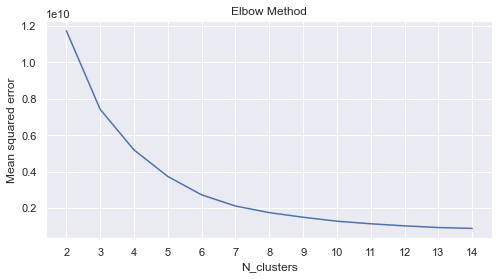

In [14]:
# Plot the Elbow Graphic
plt.figure(figsize=(8,4))
plt.plot(nclusters, inertia)
plt.xticks(nclusters)

plt.xlabel("N_clusters")
plt.ylabel("Mean squared error")
plt.title("Elbow Method")
plt.show()

In [15]:
# By looking into the elbow graphic we decided to select 4 centroids

# kmeans model, setting k = 4
km = KMeans(n_clusters = 4)
clusters=km.fit_predict(data)

# obtaining the centers of the clusters
centroids = km.cluster_centers_

# points array will be used to reach the index easy
points = np.empty((0,len(data.loc[0,:])), float)

# distances will be used to calculate outliers
distances = np.empty((0,data.shape[1]), float)

# getting points and distances
for i, center_elem in enumerate(centroids):
    # cdist is used to calculate the distance between center and other points
    distances = np.append(distances, cdist([center_elem],data[clusters == i], 'euclidean')) 
    points = np.append(points, data[clusters == i], axis=0)
    
percentile = 80
# getting outliers whose distances are greater than some percentile
outliers = points[np.where(distances > np.percentile(distances, percentile))]

In [16]:
# Transform the dataframe into an ndarray
datanp = data.values

# Match outliers with each specific row
pairwise_compare = datanp == outliers[:, np.newaxis, :]
filters3 = ~pairwise_compare.all(axis=2).any(axis=0)

techscape_3 = techscape[filters3]

perc_outliers3 = np.round((techscape.shape[0] - techscape_3.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of observations removed: {perc_outliers3}%')

Percentage of observations removed: 20.0%


In [17]:
techscape_filtered = techscape[(filters1 | filters2 | filters3)]

perc_outliers4 = np.round((techscape.shape[0] - techscape_filtered.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of outliers removed: {perc_outliers4}%')

Percentage of outliers removed: 2.31%


## !! techscape_filtered continua com outliers !!

In [18]:
techscape_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
AccountMng_Pages,9768.0,2.190008,3.128086,0.0,0.0000,1.0000,3.000000,24.0000
AccountMng_Duration,9768.0,69.062104,125.762148,1.0,1.0000,5.0000,86.750000,993.0833
FAQ_Pages,9768.0,0.435708,1.075125,0.0,0.0000,0.0000,0.000000,12.0000
FAQ_Duration,9768.0,22.890704,74.898044,1.0,1.0000,1.0000,1.000000,724.0000
Product_Pages,9768.0,29.646601,37.535022,0.0,7.0000,17.0000,37.000000,351.0000
Product_Duration,9768.0,1103.554251,1534.121915,0.5,177.9750,579.7083,1395.818725,16138.2908
GoogleAnalytics_BounceRate,9768.0,0.022680,0.049271,0.0,0.0000,0.0031,0.017400,0.2000
GoogleAnalytics_ExitRate,9768.0,0.043725,0.049239,0.0,0.0143,0.0256,0.050000,0.2000
GoogleAnalytics_PageValue,9768.0,5.653958,17.859963,0.0,0.0000,0.0000,0.000000,361.7637
Buy,9768.0,0.151720,0.358768,0.0,0.0000,0.0000,0.000000,1.0000


In [19]:
print(techscape_filtered.shape)
techscape_filtered.head(3)

(9768, 17)


,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,2020-03-21,0,1.0,0,1.0,3,64.0,0.0000,0.0667,0.0,MacOSX,2,Portugal,1,Returner,0
1,103117814,2020-05-20,0,1.0,0,1.0,23,684.5,0.0217,0.0449,0.0,Windows,2,France,6,Returner,0
2,103201891,2020-12-04,0,1.0,0,1.0,8,95.0,0.0250,0.0583,0.0,Windows,4,Italy,1,Returner,0


# Feature Engineering

In [20]:
# Create new variables

# Create binary variables for the most common operating systems
techscape_filtered['Apple'] = techscape_filtered['OS'].apply(lambda x: bool(1) if x == 'MacOSX' or x == 'iOS' else bool(0))  
techscape_filtered['Windows'] = techscape_filtered['OS'].apply(lambda x: bool(1) if x == 'Windows' else bool(0))  
techscape_filtered['Android'] = techscape_filtered['OS'].apply(lambda x: bool(1) if x == 'Android' else bool(0))


# Create binary variables for the most common countries
techscape_filtered['Portugal'] = techscape_filtered['Country'].apply(lambda x: bool(1) if x == 'Portugal' else bool(0)) 
techscape_filtered['Iberian_Peninsula'] = techscape_filtered['Country'].apply(lambda x: bool(1) if x == 'Portugal' or x == 'Spain' else bool(0))
techscape_filtered['Spain'] = techscape_filtered['Country'].apply(lambda x: bool(1) if x == 'Spain' else bool(0))


# Create binary variables for type of visitors
techscape_filtered['Returner'] = techscape_filtered['Type_of_Visitor'].apply(lambda x: bool(1) if x == 'Returner' else bool(0)) 
techscape_filtered['New_Access'] = techscape_filtered['Type_of_Visitor'].apply(lambda x: bool(1) if x == 'New_Access' else bool(0))


# Create the total duration of the visits and total number of page visits
techscape_filtered['Total_Duration'] = techscape_filtered['AccountMng_Duration'] + techscape_filtered['FAQ_Duration'] + techscape_filtered['Product_Duration']
techscape_filtered['Total_Pages'] = techscape_filtered['AccountMng_Pages'] + techscape_filtered['FAQ_Pages'] + techscape_filtered['Product_Pages']

# Correct incoherent values of total_pages and total_duration
techscape_filtered.loc[techscape_filtered['Total_Pages']==0,'Total_Pages']=1
techscape_filtered.loc[techscape_filtered['Total_Duration']==0,'Total_Duration']=1


# Create the proportion of time on each page type
techscape_filtered['PropTime_AccountMng'] = techscape_filtered['AccountMng_Duration']/techscape_filtered['Total_Duration']
techscape_filtered['PropTime_FAQ'] = techscape_filtered['FAQ_Duration']/techscape_filtered['Total_Duration']
techscape_filtered['PropTime_Product'] = techscape_filtered['Product_Duration']/techscape_filtered['Total_Duration']


# Create the proportion of visited pages of each type
techscape_filtered['PropPages_AccountMng'] = techscape_filtered['AccountMng_Pages']/techscape_filtered['Total_Pages']
techscape_filtered['PropPages_FAQ'] = techscape_filtered['FAQ_Pages']/techscape_filtered['Total_Pages']
techscape_filtered['PropPages_Product'] = techscape_filtered['Product_Pages']/techscape_filtered['Total_Pages']


# Create the average time spent per page and type of page
techscape_filtered['AvgTimePerPage'] = techscape_filtered['Total_Duration'].div(techscape_filtered['Total_Pages'].values)


techscape_filtered['AvgTimeOnAccountMng'] = techscape_filtered['AccountMng_Duration'].div(techscape_filtered['AccountMng_Pages'].values)
techscape_filtered['AvgTimeOnFAQ'] = techscape_filtered['FAQ_Duration'].div(techscape_filtered['FAQ_Pages'].values)
techscape_filtered['AvgTimeOnProduct'] = techscape_filtered['Product_Duration'].div(techscape_filtered['Product_Pages'].values)

# Correct incoherent values of AvgTimeOnAccountMng, AvgTimeOnFAQ and AvgTimeOnProduct
techscape_filtered.loc[techscape_filtered['AccountMng_Pages']==0,'AvgTimeOnAccountMng']=0
techscape_filtered.loc[techscape_filtered['FAQ_Pages']==0,'AvgTimeOnFAQ']=0
techscape_filtered.loc[techscape_filtered['Product_Pages']==0,'AvgTimeOnProduct']=0


# Create the month of the visit
techscape_filtered['Month'] = techscape_filtered['Date'].dt.month


# Create variable Covid
techscape_filtered['Covid'] = techscape_filtered['Month'].apply(lambda x: bool(1) if x>3 else bool(0))


# Create dummy variables from the categorical ones
techscape_filtered['Month'] = techscape_filtered['Month'].apply(lambda x: calendar.month_abbr[x])
month = pd.DataFrame(pd.get_dummies(techscape_filtered['Month'], drop_first = True, dtype=bool))

techscape_filtered['Type_of_Traffic'] = techscape_filtered['Type_of_Traffic'].apply(lambda x: 'Traffic_'+str(x))
type_traffic = pd.DataFrame(pd.get_dummies(techscape_filtered['Type_of_Traffic'], drop_first = True, dtype=bool))

techscape_filtered['Browser'] = techscape_filtered['Browser'].apply(lambda x: 'Browser_'+str(x))
browser = pd.DataFrame(pd.get_dummies(techscape_filtered['Browser'], drop_first = True, dtype=bool))

techscape_filtered=pd.concat((techscape_filtered,month,type_traffic,browser), axis=1)

print(techscape_filtered.shape)
display(techscape_filtered.head(3))

(9768, 73)


,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,...,Browser_11,Browser_12,Browser_13,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8
0,102863333,2020-03-21,0,1.0,0,1.0,3,64.0,0.0000,0.0667,...,False,False,False,True,False,False,False,False,False,False
1,103117814,2020-05-20,0,1.0,0,1.0,23,684.5,0.0217,0.0449,...,False,False,False,True,False,False,False,False,False,False
2,103201891,2020-12-04,0,1.0,0,1.0,8,95.0,0.0250,0.0583,...,False,False,False,False,False,True,False,False,False,False


In [21]:
techscape_filtered.drop('OS', axis=1, inplace=True)
techscape_filtered.drop('Country', axis=1, inplace=True)
techscape_filtered.drop('Type_of_Visitor', axis=1, inplace=True)
techscape_filtered.drop('Browser', axis=1, inplace=True)
techscape_filtered.drop('Type_of_Traffic', axis=1, inplace=True)
techscape_filtered.drop('Date', axis=1, inplace=True)
techscape_filtered.drop('Month', axis=1, inplace=True)

techscape_filtered.drop('Access_ID', axis=1, inplace=True)

In [22]:
print(techscape_filtered.shape)

(9768, 65)


# Data Partition



In [23]:
# Define data as all the independent variables
data = techscape_filtered.drop(['Buy'], axis=1)
# Define target as the dependent variable
target = techscape_filtered['Buy']


# -----------------------
X_train, X_val, y_train, y_val = train_test_split(data, target, train_size=0.75, stratify = target, random_state=5)
# Train 0.75 || Valid 0.25
# Stratify so we have the same values in target in the train and val datasets


# -----------------------
X_train_metric = X_train.select_dtypes(include=np.number).set_index(X_train.index)
X_train_non_metric = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

X_val_metric = X_val.select_dtypes(include=np.number).set_index(X_val.index)
X_val_non_metric = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

In [24]:
# -------------- SCALLING --------------

scaler = MinMaxScaler().fit(X_train_metric)

X_train_metric_scaled = scaler.transform(X_train_metric)
X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train_metric.columns).set_index(X_train.index)

X_val_metric_scaled = scaler.transform(X_val_metric)
X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val_metric.columns).set_index(X_val.index)

# Feature Selection

Filter Methods:

In [25]:
# ------------ Univariate Variables ------------

# Check if any of the variables is univariate
X_train_metric_scaled.var()

# There aren't univariate variables
# Keep: all
# Remove: none

AccountMng_Pages              0.017440
AccountMng_Duration           0.015717
FAQ_Pages                     0.008446
FAQ_Duration                  0.010980
Product_Pages                 0.011250
Product_Duration              0.008851
GoogleAnalytics_BounceRate    0.059482
GoogleAnalytics_ExitRate      0.059924
GoogleAnalytics_PageValue     0.002691
Total_Duration                0.009443
Total_Pages                   0.011067
PropTime_AccountMng           0.023269
PropTime_FAQ                  0.011451
PropTime_Product              0.042947
PropPages_AccountMng          0.016010
PropPages_FAQ                 0.002160
PropPages_Product             0.019971
AvgTimePerPage                0.000947
AvgTimeOnAccountMng           0.003492
AvgTimeOnFAQ                  0.003069
AvgTimeOnProduct              0.001038
dtype: float64

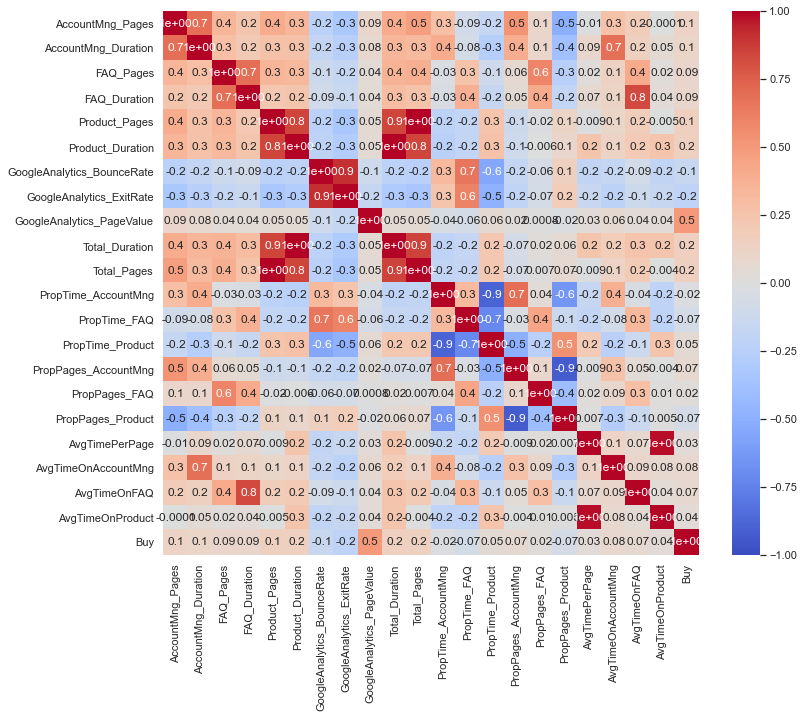

In [230]:
# ------------ Spearman Correlation ------------

# Check correlations
all_train_metric = X_train_metric_scaled.join(y_train)
all_train_metric.head()

corr = all_train_metric.corr(method = 'pearson')  # or spearman

def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, vmin=-1, vmax=1, annot = True, cmap ="coolwarm" , fmt='.1')

    plt.show()
    
cor_heatmap(corr) 

In [231]:
# Better visualization of correlation values (numerical data)

corr.style.applymap(lambda x: 'background-color : green' if x > 0.85 else ('background-color : red' if x < -0.85 else ''))

# Higly correlated variables:
# Product_Pages - Product_Duration
# Product_Pages - Total_Pages
# Product_Duration - Total_Pages
# Product_Duration - Total_Duration
# GoogleAnalytics_BounceRate - GoogleAnalytics_ExitRate
# PropTime_AccountMng - PropTime_Product
# PropPages_AccountMng - PropPages_Product
# AvgTimePerPage - AvgTimeOnProduct

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Total_Duration,Total_Pages,PropTime_AccountMng,PropTime_FAQ,PropTime_Product,PropPages_AccountMng,PropPages_FAQ,PropPages_Product,AvgTimePerPage,AvgTimeOnAccountMng,AvgTimeOnFAQ,AvgTimeOnProduct,Buy
AccountMng_Pages,1.000000,0.694542,0.350720,0.248374,0.403587,0.348502,-0.227136,-0.321109,0.094378,0.402001,0.476079,0.283480,-0.086533,-0.166508,0.530323,0.099217,-0.503386,-0.013986,0.265639,0.193378,-0.000104,0.127841
AccountMng_Duration,0.694542,1.000000,0.283477,0.213842,0.268041,0.270518,-0.178093,-0.254170,0.075085,0.349384,0.320081,0.405582,-0.075735,-0.261439,0.395243,0.101154,-0.383979,0.088509,0.683716,0.154827,0.053573,0.102707
FAQ_Pages,0.350720,0.283477,1.000000,0.690414,0.345185,0.323896,-0.119812,-0.169504,0.041926,0.367147,0.385995,-0.025319,0.258385,-0.106164,0.063939,0.600819,-0.252487,0.020637,0.139416,0.411317,0.017960,0.093933
FAQ_Duration,0.248374,0.213842,0.690414,1.000000,0.231410,0.248942,-0.092805,-0.135166,0.039525,0.304402,0.260410,-0.034420,0.380784,-0.158580,0.054332,0.413056,-0.182784,0.065641,0.119254,0.833199,0.037060,0.087162
Product_Pages,0.403587,0.268041,0.345185,0.231410,1.000000,0.849933,-0.226656,-0.320583,0.046928,0.850044,0.996397,-0.221800,-0.181096,0.250418,-0.120423,-0.019007,0.118690,-0.009322,0.106434,0.178487,-0.004649,0.149694
Product_Duration,0.348502,0.270518,0.323896,0.248942,0.849933,1.000000,-0.213246,-0.287657,0.046944,0.995475,0.848177,-0.245597,-0.185202,0.269887,-0.105654,-0.005727,0.100682,0.242437,0.128497,0.209018,0.252458,0.150139
GoogleAnalytics_BounceRate,-0.227136,-0.178093,-0.119812,-0.092805,-0.226656,-0.213246,1.000000,0.912135,-0.116399,-0.223679,-0.237959,0.313288,0.662522,-0.550110,-0.165817,-0.064279,0.148888,-0.191679,-0.164840,-0.085308,-0.193466,-0.149373
GoogleAnalytics_ExitRate,-0.321109,-0.254170,-0.169504,-0.135166,-0.320583,-0.287657,0.912135,1.000000,-0.169298,-0.303308,-0.336600,0.254685,0.603580,-0.478588,-0.200731,-0.070501,0.184718,-0.155893,-0.220262,-0.122366,-0.159957,-0.205958
GoogleAnalytics_PageValue,0.094378,0.075085,0.041926,0.039525,0.046928,0.046944,-0.116399,-0.169298,1.000000,0.052986,0.053606,-0.042457,-0.064618,0.062399,0.022860,0.000841,-0.018939,0.033384,0.063194,0.035197,0.036380,0.494188
Total_Duration,0.402001,0.349384,0.367147,0.304402,0.850044,0.995475,-0.223679,-0.303308,0.052986,1.000000,0.853848,-0.205996,-0.165888,0.231463,-0.067897,0.022295,0.057833,0.243401,0.183259,0.253327,0.248917,0.156744


Wrapper and Embeded Methods:

In [28]:
# Get all the metric and non metric variables
data_metric = data.select_dtypes(include=np.number).set_index(data.index)
data_non_metric = data.select_dtypes(exclude=np.number).set_index(data.index)

# Create a Startified KFold with 10 splits
skf = StratifiedKFold(n_splits=10)

In [30]:
# ----------------------------- Lasso and Decision Tree -----------------------------
fold = 1

for train_index, val_index in skf.split(data_metric, target):
        
        # Data Partition
        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        
        # Scaling the data with MinMaxScaler
        scaler = MinMaxScaler().fit(X_train)
        
        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)

        X_val_metric_scaled = scaler.transform(X_val)
        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
        
        
        # CODE FOR LASSO
        reg = LassoCV()
        lasso = reg.fit(X_train_metric_scaled, y_train)
        importance = np.abs(lasso.coef_)
        #print(importance)
        
        # CODE FOR DT
        gini_importance = DecisionTreeClassifier().fit(X = X_train_metric_scaled, y = y_train).feature_importances_
        entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X = X_train_metric_scaled, y = y_train).feature_importances_
        
    
        
        if fold == 1:
            # Create three empty data frames
            lasso_results = pd.DataFrame(index = X_train_metric_scaled.columns)
            gini_results = pd.DataFrame(index = X_train_metric_scaled.columns)
            entropy_results = pd.DataFrame(index = X_train_metric_scaled.columns)
            
        importance_values = pd.Series(importance, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
        gini_values = pd.Series(gini_importance, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
        entropy_values = pd.Series(entropy_importance, index = X_train_metric_scaled.columns, name=f'Partition {fold}')

        lasso_results = pd.concat((lasso_results, importance_values), axis=1)
        gini_results = pd.concat((gini_results, gini_values), axis=1)
        entropy_results = pd.concat((entropy_results, entropy_values), axis=1)
        
        fold+=1
               
        
# Add new column with average of importance        
importance_lasso_list = []
importance_gini_list = []
importance_entropy_list = []

for index, row in lasso_results.iterrows():
    count = 0
    for elem in row:
        count+=elem
    average = count / 10
    importance_lasso_list.append(average)

for index, row in gini_results.iterrows():
    count = 0
    for elem in row:
        count+=elem
    average = count / 10
    importance_gini_list.append(average)
    
for index, row in entropy_results.iterrows():
    count = 0
    for elem in row:
        count+=elem
    average = count / 10
    importance_entropy_list.append(average)

lasso_results['Average of LASSO Importance'] = importance_lasso_list 
gini_results['Average of Gini Importance'] = importance_gini_list
entropy_results['Average of Entropy Importance'] = importance_entropy_list
dt_results = pd.merge(gini_results['Average of Gini Importance'], entropy_results['Average of Entropy Importance'], left_index = True, right_index = True)
importance_results = pd.merge(dt_results, lasso_results['Average of LASSO Importance'], left_index = True, right_index = True)

#lasso_results.style.applymap(lambda x: 'background-color : green' if x > 0.01 else ('background-color : red' if x < -0.85 else ''))

importance_results.sort_values(by=['Average of LASSO Importance','Average of Gini Importance','Average of Entropy Importance'], ascending=False)

,Average of Gini Importance,Average of Entropy Importance,Average of LASSO Importance
GoogleAnalytics_PageValue,0.421943,0.403184,3.417287
GoogleAnalytics_ExitRate,0.058380,0.067994,0.196111
Product_Duration,0.030407,0.035176,0.181875
Total_Duration,0.031396,0.030513,0.126082
Product_Pages,0.023628,0.037359,0.125998
PropPages_AccountMng,0.028898,0.031108,0.096863
AvgTimeOnAccountMng,0.029100,0.033689,0.073381
GoogleAnalytics_BounceRate,0.063600,0.053175,0.056427
AccountMng_Pages,0.022868,0.012143,0.044217
PropTime_FAQ,0.035464,0.031973,0.041475


In [33]:
 #----------------------------- RFE -----------------------------
fold = 1

for train_index, val_index in skf.split(data_metric, target):
        
        # Data Partition
        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        
        # Scaling the data with MinMaxScaler
        scaler = MinMaxScaler().fit(X_train)
        
        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)

        X_val_metric_scaled = scaler.transform(X_val)
        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
        
        
        # CODE FOR RFE
        nof_list = np.arange(1,len(data_metric.columns)+1)  # Array from 1 to 21           
        high_score = 0
        nof = 0  # Variable to store the optimum number of features
        
        for n in nof_list:
            
            model = LogisticRegression()
            rfe = RFE(model, n)
            
            X_train_rfe = rfe.fit_transform(X_train_metric_scaled,y_train)
            X_val_rfe = rfe.transform(X_val_metric_scaled)
            
            model.fit(X_train_rfe,y_train)

            score = model.score(X_val_rfe,y_val)
            
            if (score > high_score):
                high_score = score
                nof = n
                selected_features = pd.Series(rfe.support_, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
                
        if fold == 1:
            # Create empty data frame
            rfe_results = pd.DataFrame(index = X_train_metric_scaled.columns)
        
        # Concatenate variables chosen at each partition
        rfe_results = pd.concat((rfe_results, selected_features), axis=1)
        
        print('Pão pão queijo queijo')
        fold+=1

# Add new column with count of True's        
count_rfe_list = []
for index, row in rfe_results.iterrows():
    count = 0
    for elem in row:
        if elem == True:
            count+=1
    count_rfe_list.append(count)

rfe_results['Count'] = count_rfe_list

rfe_results.sort_values(by='Count', ascending=False)

Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo


,Partition 1,Partition 2,Partition 3,Partition 4,Partition 5,Partition 6,Partition 7,Partition 8,Partition 9,Partition 10,Count
GoogleAnalytics_ExitRate,True,True,True,True,True,True,True,True,True,True,10
GoogleAnalytics_PageValue,True,True,True,True,True,True,True,True,True,True,10
Total_Duration,False,False,True,True,False,False,True,True,True,False,5
Product_Duration,False,False,True,False,False,False,False,True,True,False,3
AvgTimeOnAccountMng,False,False,True,False,False,False,False,True,True,False,3
PropPages_AccountMng,False,False,True,False,False,False,False,True,True,False,3
FAQ_Duration,False,False,False,False,False,False,False,True,True,False,2
Product_Pages,False,False,False,False,False,False,False,True,True,False,2
GoogleAnalytics_BounceRate,False,False,False,False,False,False,False,True,True,False,2
PropPages_Product,False,False,False,False,False,False,False,False,True,False,1


In [34]:
# ------------ Backward Regression  ------------
fold = 1

for train_index, val_index in skf.split(data_metric, target):
        
        # Data Partition
        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        
        # Scaling the data with MinMaxScaler
        scaler = MinMaxScaler().fit(X_train)
        
        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)

        X_val_metric_scaled = scaler.transform(X_val)
        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
        
        
        # CODE FOR BACKWARD REGRESSION
        sfs_backward = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=5, direction="backward")
        sfs_backward.fit(X = X_train_metric_scaled, y = y_train)

        selected_features = pd.Series(sfs_backward.support_, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
        
        if fold == 1:
            # Create empty data frame
            backward_results = pd.DataFrame(index = X_train_metric_scaled.columns)
            
        backward_results = pd.concat((backward_results, selected_features), axis=1)
        
        print('Grão a grão enche a galinha o papo')
        fold+=1
        
        
# Add new column with count of True's        
count_backward_list = []
for index, row in backward_results.iterrows():
    count = 0
    for elem in row:
        if elem == True:
            count+=1
    count_backward_list.append(count)

backward_results['Count'] = count_backward_list 
backward_results.sort_values(by='Count', ascending=False)

Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo


,Partition 1,Partition 2,Partition 3,Partition 4,Partition 5,Partition 6,Partition 7,Partition 8,Partition 9,Partition 10,Count
GoogleAnalytics_ExitRate,True,True,True,True,True,True,True,True,True,True,10
GoogleAnalytics_PageValue,True,True,True,True,True,True,True,True,True,True,10
FAQ_Duration,True,True,True,False,False,False,False,True,True,True,6
PropTime_Product,True,False,False,False,True,False,True,False,False,False,3
AvgTimeOnFAQ,False,False,False,False,True,True,True,False,False,False,3
AvgTimeOnAccountMng,False,False,True,True,True,False,False,False,False,False,3
GoogleAnalytics_BounceRate,True,False,False,True,False,False,False,False,False,True,3
AvgTimeOnProduct,False,False,False,False,False,True,False,True,False,False,2
AvgTimePerPage,False,False,False,False,False,True,False,True,False,False,2
PropPages_AccountMng,False,False,False,False,False,False,False,False,True,True,2


In [35]:
# ------------ Forward Regression  ------------
fold = 1

for train_index, val_index in skf.split(data_metric, target):
        
        # Data Partition
        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        
        # Scaling the data with MinMaxScaler
        scaler = MinMaxScaler().fit(X_train)
        
        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)

        X_val_metric_scaled = scaler.transform(X_val)
        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
        
        
        # CODE FOR FORWARD REGRESSION
        sfs_forward = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=5, direction="forward")
        sfs_forward.fit(X = X_train_metric_scaled, y = y_train)

        selected_features = pd.Series(sfs_forward.support_, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
        
        if fold == 1:
            # Create empty data frame
            forward_results = pd.DataFrame(index = X_train_metric_scaled.columns)
            
        forward_results = pd.concat((forward_results, selected_features), axis=1)
        
        print('Grão a grão enche a galinha o papo')
        fold+=1
        
        
# Add new column with count of True's        
count_forward_list = []
for index, row in forward_results.iterrows():
    count = 0
    for elem in row:
        if elem == True:
            count+=1
    count_forward_list.append(count)

forward_results['Count'] = count_forward_list 

forward_results.sort_values(by='Count', ascending=False)

Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo


,Partition 1,Partition 2,Partition 3,Partition 4,Partition 5,Partition 6,Partition 7,Partition 8,Partition 9,Partition 10,Count
GoogleAnalytics_ExitRate,True,True,True,True,True,True,True,True,True,True,10
GoogleAnalytics_PageValue,True,True,True,True,True,True,True,True,True,True,10
GoogleAnalytics_BounceRate,True,True,True,True,False,True,True,True,True,False,8
AvgTimeOnFAQ,False,True,False,True,True,True,True,False,True,False,6
PropPages_FAQ,False,False,True,False,False,True,True,True,True,False,5
PropTime_FAQ,False,True,False,True,True,False,False,False,False,True,4
AvgTimePerPage,False,False,False,False,True,False,False,True,False,True,3
FAQ_Duration,True,False,True,False,False,False,False,False,False,False,2
PropTime_Product,True,False,False,False,False,False,False,False,False,False,1
AvgTimeOnAccountMng,False,False,False,False,False,False,False,False,False,True,1


In [36]:
# ------------ Select From Model ------------
fold = 1

for train_index, val_index in skf.split(data_metric, target):
        
        # Data Partition
        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        
        # Scaling the data with MinMaxScaler
        scaler = MinMaxScaler().fit(X_train)
        
        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)

        X_val_metric_scaled = scaler.transform(X_val)
        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
        
        
        # CODE FOR SELECT FROM MODEL
        threshold = np.sort(importance)[-3] + 0.01

        sfm = SelectFromModel(lasso, threshold=threshold)
        sfm.fit(X = X_train_metric_scaled, y = y_train)

        selected_features = pd.Series(sfm.get_support(), index = X_train_metric_scaled.columns, name=f'Partition {fold}')
        
        if fold == 1:
            sfm_results = pd.DataFrame(index = X_train_metric_scaled.columns)
            
        sfm_results = pd.concat((sfm_results, selected_features), axis=1)
        
        fold+=1
        
        
# Add new column with count of True's        
count_sfm_list = []
for index, row in sfm_results.iterrows():
    count = 0
    for elem in row:
        if elem == True:
            count+=1
    count_sfm_list.append(count)

sfm_results['Count'] = count_sfm_list 

sfm_results.sort_values(by='Count', ascending=False)

,Partition 1,Partition 2,Partition 3,Partition 4,Partition 5,Partition 6,Partition 7,Partition 8,Partition 9,Partition 10,Count
GoogleAnalytics_PageValue,True,True,True,True,True,True,True,True,True,True,10
Product_Duration,False,True,True,False,True,False,True,True,False,True,6
Total_Duration,True,False,False,True,False,True,False,False,True,False,4
GoogleAnalytics_ExitRate,False,True,False,False,False,False,False,False,False,False,1
AccountMng_Pages,False,False,False,False,False,False,False,False,False,False,0
PropTime_Product,False,False,False,False,False,False,False,False,False,False,0
AvgTimeOnFAQ,False,False,False,False,False,False,False,False,False,False,0
AvgTimeOnAccountMng,False,False,False,False,False,False,False,False,False,False,0
AvgTimePerPage,False,False,False,False,False,False,False,False,False,False,0
PropPages_Product,False,False,False,False,False,False,False,False,False,False,0


In [37]:
# Final table 
final_results = pd.DataFrame(index = X_train_metric_scaled.columns)

final_results['Count RFE'] = count_rfe_list
final_results['Count Backward'] = count_backward_list
final_results['Count Forward'] = count_forward_list
final_results['Count SFM'] = count_sfm_list

final_results['Average Importance Lasso'] = importance_results['Average of LASSO Importance']
final_results['Average Importance Gini'] = importance_results['Average of Gini Importance']
final_results['Average Importance Entropy'] = importance_results['Average of Entropy Importance']

final_results.sort_values(by = ['Average Importance Lasso', 'Average Importance Gini', 'Average Importance Entropy'], ascending = False, inplace = True)
final_results

,Count RFE,Count Backward,Count Forward,Count SFM,Average Importance Lasso,Average Importance Gini,Average Importance Entropy
GoogleAnalytics_PageValue,10,10,10,10,3.417287,0.421943,0.403184
GoogleAnalytics_ExitRate,10,10,10,1,0.196111,0.058380,0.067994
Product_Duration,3,0,0,6,0.181875,0.030407,0.035176
Total_Duration,5,1,0,4,0.126082,0.031396,0.030513
Product_Pages,2,0,0,0,0.125998,0.023628,0.037359
PropPages_AccountMng,3,2,0,0,0.096863,0.028898,0.031108
AvgTimeOnAccountMng,3,3,1,0,0.073381,0.029100,0.033689
GoogleAnalytics_BounceRate,2,3,8,0,0.056427,0.063600,0.053175
AccountMng_Pages,0,0,0,0,0.044217,0.022868,0.012143
PropTime_FAQ,0,1,4,0,0.041475,0.035464,0.031973


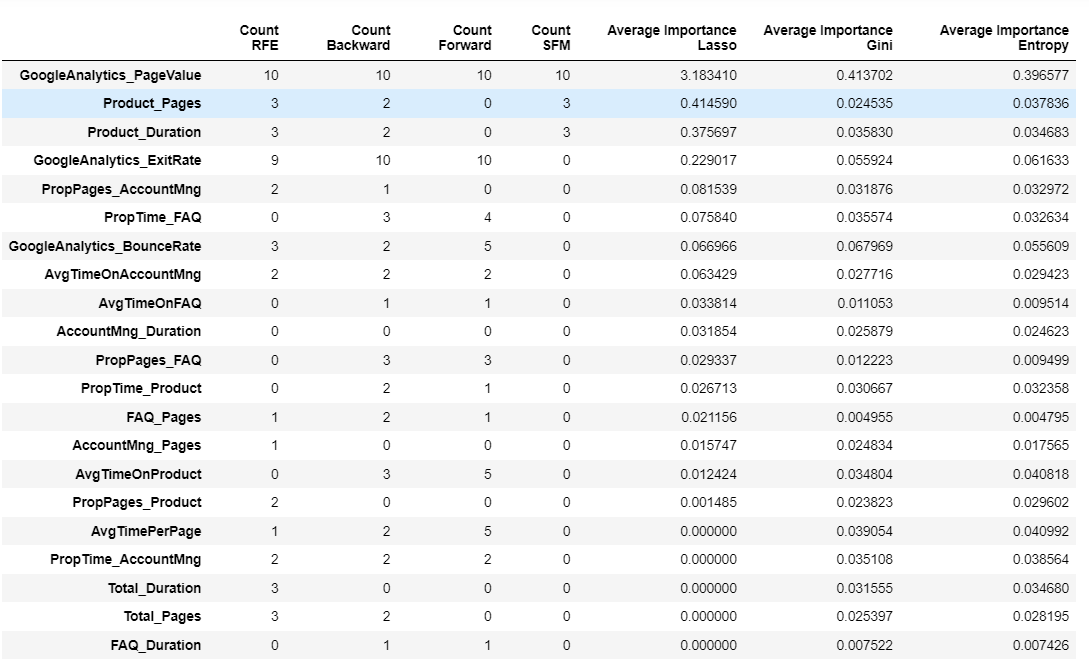

In [38]:
# Chi-Square for categorical data

fold = 1

for train_index, val_index in skf.split(data_non_metric, target):
        
        # Data Partition
        X_train, X_val = data_non_metric.iloc[train_index], data_non_metric.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        
        # CODE FOR Chi-Square
        if fold == 1:
            chi_square_results = pd.DataFrame(index = X_train.columns)
        
        importance_list = []
        
        for var in data_non_metric:
            
            dfObserved = pd.crosstab(y_train, X_train[var]) 
            chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
            dfExpected = pd.DataFrame(expected, columns = dfObserved.columns, index = dfObserved.index)

            if p < 0.05:
                importance_list.append(True)
            else: 
                importance_list.append(False)
            
        selected_features = pd.Series(importance_list, index = X_train.columns, name=f'Partition {fold}')    
      
        chi_square_results = pd.concat((chi_square_results, selected_features), axis=1)
        
        fold+=1
        
        
# Add new column with count of True's        
count_chi_square_list = []
for index, row in chi_square_results.iterrows():
    count = 0
    for elem in row:
        if elem == True:
            count+=1
    count_chi_square_list.append(count)

chi_square_results['Count'] = count_chi_square_list 

chi_square_results.sort_values(by='Count', ascending=False, inplace = True)

chi_square_results['Keep'] = chi_square_results['Count'].apply(lambda x: 'Yes' if x == 10 else 'No')
chi_square_results[chi_square_results['Keep'] == 'Yes']

,Partition 1,Partition 2,Partition 3,Partition 4,Partition 5,Partition 6,Partition 7,Partition 8,Partition 9,Partition 10,Count,Keep
Apple,True,True,True,True,True,True,True,True,True,True,10,Yes
Mar,True,True,True,True,True,True,True,True,True,True,10,Yes
Traffic_8,True,True,True,True,True,True,True,True,True,True,10,Yes
Traffic_3,True,True,True,True,True,True,True,True,True,True,10,Yes
Traffic_2,True,True,True,True,True,True,True,True,True,True,10,Yes
Windows,True,True,True,True,True,True,True,True,True,True,10,Yes
Traffic_12,True,True,True,True,True,True,True,True,True,True,10,Yes
Oct,True,True,True,True,True,True,True,True,True,True,10,Yes
Nov,True,True,True,True,True,True,True,True,True,True,10,Yes
May,True,True,True,True,True,True,True,True,True,True,10,Yes


In [39]:
# Check the correlations between the boolean variables

X_train_non_metric_corr = pd.DataFrame()

X_train_non_metric_corr['Apple'] = X_train_non_metric['Apple'].apply(lambda x: 1 if x == True else 0)
X_train_non_metric_corr['Windows'] = X_train_non_metric['Windows'].apply(lambda x: 1 if x == True else 0)

X_train_non_metric_corr['Returner'] = X_train_non_metric['Returner'].apply(lambda x: 1 if x == True else 0)
X_train_non_metric_corr['New_Access'] = X_train_non_metric['New_Access'].apply(lambda x: 1 if x == True else 0)

X_train_non_metric_corr['Covid'] = X_train_non_metric['Covid'].apply(lambda x: 1 if x == True else 0)

X_train_non_metric_corr['Dec'] = X_train_non_metric['Dec'].apply(lambda x: 1 if x == True else 0)
X_train_non_metric_corr['Feb'] = X_train_non_metric['Feb'].apply(lambda x: 1 if x == True else 0)
X_train_non_metric_corr['Mar'] = X_train_non_metric['Mar'].apply(lambda x: 1 if x == True else 0)
X_train_non_metric_corr['May'] = X_train_non_metric['May'].apply(lambda x: 1 if x == True else 0)
X_train_non_metric_corr['Nov'] = X_train_non_metric['Nov'].apply(lambda x: 1 if x == True else 0)
X_train_non_metric_corr['Oct'] = X_train_non_metric['Oct'].apply(lambda x: 1 if x == True else 0)

X_train_non_metric_corr['Traffic_12'] = X_train_non_metric['Traffic_12'].apply(lambda x: 1 if x == True else 0)
X_train_non_metric_corr['Traffic_13'] = X_train_non_metric['Traffic_13'].apply(lambda x: 1 if x == True else 0)
X_train_non_metric_corr['Traffic_2'] = X_train_non_metric['Traffic_2'].apply(lambda x: 1 if x == True else 0)
X_train_non_metric_corr['Traffic_3'] = X_train_non_metric['Traffic_3'].apply(lambda x: 1 if x == True else 0)
X_train_non_metric_corr['Traffic_8'] = X_train_non_metric['Traffic_8'].apply(lambda x: 1 if x == True else 0)


print(X_train_non_metric_corr.shape)
X_train_non_metric_corr.head(3)

(7326, 16)


,Apple,Windows,Returner,New_Access,Covid,Dec,Feb,Mar,May,Nov,Oct,Traffic_12,Traffic_13,Traffic_2,Traffic_3,Traffic_8
1291,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0
5968,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0
5492,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0


In [269]:
corr_bin = X_train_non_metric_corr.corr(method = 'pearson')
corr_bin.style.applymap(lambda x: 'background-color : green' if x > 0.85 else ('background-color : red' if x < -0.85 else ''))

# Conclusions:
#
#
#


,Apple,Windows,Returner,New_Access,Covid,Dec,Feb,Mar,May,Nov,Oct,Traffic_12,Traffic_13,Traffic_2,Traffic_3,Traffic_8
Apple,1.000000,-0.602937,0.043143,-0.033549,0.001928,-0.009024,-0.014989,0.003112,0.003675,0.004723,-0.009024,0.002422,0.158232,-0.087191,-0.001809,0.002030
Windows,-0.602937,1.000000,-0.000432,0.012810,-0.001171,-0.015202,-0.013655,0.005876,0.033757,-0.021322,-0.009024,-0.048460,-0.025969,0.053654,-0.057164,-0.020871
Returner,0.043143,-0.000432,1.000000,-0.969861,-0.049013,-0.100208,0.050007,0.033853,0.101094,-0.015302,-0.064610,0.009740,0.099407,-0.201760,0.095409,-0.173426
New_Access,-0.033549,0.012810,-0.969861,1.000000,0.040077,0.064829,-0.048340,-0.025138,-0.089782,0.014888,0.070674,-0.008528,-0.096156,0.212605,-0.093963,0.178395
Covid,0.001928,-0.001171,-0.049013,0.040077,1.000000,0.183563,-0.275898,-0.944687,0.283095,0.254018,0.097343,0.013168,0.090446,0.044224,-0.046811,-0.025600
Dec,-0.009024,-0.015202,-0.100208,0.064829,0.183563,1.000000,-0.050645,-0.173410,-0.248036,-0.222559,-0.085288,-0.026143,-0.053888,0.119143,-0.079357,0.049516
Feb,-0.014989,-0.013655,0.050007,-0.048340,-0.275898,-0.050645,1.000000,-0.054606,-0.078105,-0.070083,-0.026857,-0.008232,-0.031339,-0.050217,0.108043,-0.020828
Mar,0.003112,0.005876,0.033853,-0.025138,-0.944687,-0.173410,-0.054606,1.000000,-0.267436,-0.239967,-0.091958,-0.010870,-0.083264,-0.028806,0.011762,0.033701
May,0.003675,0.033757,0.101094,-0.089782,0.283095,-0.248036,-0.078105,-0.267436,1.000000,-0.343235,-0.131532,0.081897,0.093206,-0.136520,0.081310,-0.102006
Nov,0.004723,-0.021322,-0.015302,0.014888,0.254018,-0.222559,-0.070083,-0.239967,-0.343235,1.000000,-0.118022,-0.031221,0.020545,0.115863,-0.049896,0.112849


# Choose the most relevant features

In [40]:
selected_variables = ['GoogleAnalytics_PageValue', 'GoogleAnalytics_ExitRate', 'Product_Pages', 'AvgTimeOnAccountMng', 'PropPages_AccountMng','PropTime_FAQ', 'Apple', 'Dec', 'Covid', 'Windows', 'New_Access']

data_select_features = data[selected_variables]
#data_select_features[['Apple', 'Covid', 'Windows', 'Returner']]=data_select_features[['Apple', 'Covid', 'Windows', 'Returner']].astype('category')

print(data_select_features.shape)
data_select_features.head(3)

(9768, 11)


,GoogleAnalytics_PageValue,GoogleAnalytics_ExitRate,Product_Pages,AvgTimeOnAccountMng,PropPages_AccountMng,PropTime_FAQ,Apple,Dec,Covid,Windows,New_Access
0,0.0,0.0667,3,0.0,0.0,0.015152,True,False,False,False,False
1,0.0,0.0449,23,0.0,0.0,0.001457,False,False,True,True,False
2,0.0,0.0583,8,0.0,0.0,0.010309,False,True,True,True,False


## TEM OULIERS!!

In [41]:
data_select_features.describe().T

,count,mean,std,min,25%,50%,75%,max
GoogleAnalytics_PageValue,9768.0,5.653958,17.859963,0.00000,0.000000,0.000000,0.000000,361.763700
GoogleAnalytics_ExitRate,9768.0,0.043725,0.049239,0.00000,0.014300,0.025600,0.050000,0.200000
Product_Pages,9768.0,29.646601,37.535022,0.00000,7.000000,17.000000,37.000000,351.000000
AvgTimeOnAccountMng,9768.0,18.092944,35.348768,0.00000,0.000000,4.000000,23.248929,702.000000
PropPages_AccountMng,9768.0,0.079281,0.127251,0.00000,0.000000,0.019231,0.113636,1.000000
PropTime_FAQ,9768.0,0.041446,0.099416,0.00007,0.001022,0.002929,0.016445,0.965517


<a class="anchor" id="15th-bullet">

## Final Insights:
    
</a>

<hr>

### Numerical Data

| Predictor | Spearman | RFE | Lasso | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- |--- |
| AccountMng_Pages | Discard | Keep | Keep ?| Include in the model |
| AccountMng_Duration | Discard | Keep | Keep | Include in the model |
| FAQ_Pages | Discard | Discard | Keep | Try with and without |
| FAQ_Duration | Discard | Discard | Discard |  Discard |
| Product_Pages | Discard | Discard | Discard |  Discard |
| Product_Duration | Discard | Keep | Keep | Include in the model |
| GoogleAnalytics_BounceRate | Discard | Discard | Keep ? | Discard |
| GoogleAnalytics_ExitRate | Discard | Keep | Keep ?| Include in the model |
| GoogleAnalytics_PageValue | Discard | Keep | Keep | Include in the model |
| Total_Duration | Discard | Discard | Discard |  Discard |
| Total_Pages | Discard | Keep | Keep | Include in the model |
| PropTime_AccountMng | Discard | Discard | Discard |  Discard |
| PropTime_FAQ | Discard | Discard | Discard |  Discard |
| PropTime_Product | Discard | Keep | Keep | Include in the model |
| PropPages_AccountMng | Discard | Discard | Keep ? | Discard |
| PropPages_FAQ | Discard | Keep | Keep ?| Include in the model |
| PropPages_Product | Discard | Keep | Keep | Include in the model |
| AvgTimeOnAccountMng | Discard | Discard | Keep | Try with and without |
| AvgTimeOnFAQ | Discard | Discard | Keep | Try with and without |
| AvgTimeOnProduct | Discard | Discard | Keep | Try with and without |
| Month | Discard | Discard | Discard |  Discard | 


<hr>


### Categorical Data

| Predictor | Chi-Square | 
| --- | --- | 
| OS | Keep |  
| Country | Discard | 
| Type_of_Visitor | Keep |

<hr>

# Model Evaluation

In [42]:
def avg_score(model, split_method, scaler_method, X, y):
    
    score_train = []
    score_val = []
    
    for train_index, test_index in split_method.split(X, y=target):
        
        # Data Partition
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        # Separate X_train in metric and non metric features
        X_train_metric = X_train.select_dtypes(include=np.number).set_index(X_train.index)
        X_train_non_metric = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)
        
        # Separate X_val in metric and non metric features
        X_val_metric = X_val.select_dtypes(include=np.number).set_index(X_val.index)
        X_val_non_metric = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)
        
        
        # Create a scalling method        
        scaler = scaler_method.fit(X_train_metric)
        
        # Scalling the X_train_metric
        X_train_metric_scaled = scaler.transform(X_train_metric) 
        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train_metric.columns).set_index(X_train.index)
        
        # Scalling the X_val_metric
        X_val_metric_scaled = scaler.transform(X_val_metric) 
        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val_metric.columns).set_index(X_val.index)
            
            
        # Join the X_train and X_val back together
        X_train_final = X_train_metric_scaled.join(X_train_non_metric)
        X_val_final = X_val_metric_scaled.join(X_val_non_metric)     

        
        # Define our model and fit to our scalled data
        model = model.fit(X_train_final, y_train)
        
        
        # Predict the dependent variable
        y_train_pred = model.predict(X_train_final)
        y_val_pred = model.predict(X_val_final)
        
        # Calculate de f1 score
        value_train = f1_score(y_train, y_train_pred)
        value_val = f1_score(y_val, y_val_pred)        
        
        score_train.append(value_train)
        score_val.append(value_val)

    print('Average score of Train:', round(np.mean(score_train), 5))
    print('Average score of Valid:', round(np.mean(score_val), 5))
    print(f'Difference between Train and Validation: {round(np.mean(score_train)-np.mean(score_val), 5)}')

### Grids for parameters testing

In [44]:
# Traind test split
X_train, X_val, y_train, y_val = train_test_split(data_select_features, target, test_size = 0.2, random_state = 15, stratify = target)

# Decision Tree Grid
param_dt = {
    'criterion': ['entropy'], #, 'entropy'],
    'splitter': ['best'], # 'random'],
    'max_depth': [2,3,4,5,6],
    
    'min_samples_split': [100,200,300],
    'min_samples_leaf': [100,200,300],
    
#    'min_weight_fraction_leaf': [0.0],
    'max_features': [2,4,6,8, None],
#   'random_state'=None,
    'max_leaf_nodes': [4,8,12, None],
#    'min_impurity_decrease'=0.0,
#    'min_impurity_split'=None,
#    'class_weight'=None,
#    'ccp_alpha'=0.0,
    }

grid_dt = GridSearchCV(DecisionTreeClassifier() , param_dt, scoring = 'f1')
grid_dt.fit(X_train, y_train)
grid_dt.best_params_, grid_dt.best_score_

KeyboardInterrupt: 

In [ ]:
# KNN Grid
param_gb = {
    'max_depth':range(5,16,2), 
    'min_samples_split':range(200,1001,200),
    'n_estimators':range(100,500,50),
    'learning_rate' : [ 0.001, 0.01, 0.1, 0.2],
    'max_features': ['sqrt'],
    'subsample': [0.8]
}

grid_gb = GridSearchCV(estimator = GradientBoostingClassifier( random_state=10), 
        param_grid = param_gb, scoring='f1',n_jobs=4, cv=5)
grid_gb.fit(X_train,y_train)
grid_gb.best_params_, grid_nn.best_score_

In [ ]:
# Neural Networks Grid
param_nn = {
#    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter' : [100],
}

grid_nn = GridSearchCV(MLPClassifier(),scoring='f1', param_grid = param_nn, n_jobs=-1, cv=10)
grid_nn.fit(X_train,y_train)
grid_nn.best_score_, grid_nn.best_params_

In [370]:
# XGBoost grid
param_xgb = {
        'booster': ['gbtree'],
        # verbosity
        'max_depth': [3,5,8],
        'learning_rate': [0.05, 0.1, 0.3],
        'n_estimators': [100, 500, 1000],
        'colsample_bytree': [0.3, 0.7],
        'gamma':[1,5, 20],
        'min_child_weight': [1,1.5]
}

grid_xgb = GridSearchCV(XGBClassifier(), param_grid = param_xgb, scoring='f1', n_jobs=-1, cv=3)
grid_xgb.fit(X_train,y_train)
grid_xgb.best_score_, grid_xgb.best_params_

#params={ #'objective':'reg:squarederror',
#         'max_depth': range(2,15,3), 
#         'colsample_bylevel':0.5,
#         'learning_rate':0.01,
#         'random_state':20,
#         'min_child_weight':,
#         'gamma':

[14:26:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.8971861471861472,
 {'booster': 'gbtree',
  'colsample_bytree': 0.7,
  'gamma': 5,
  'learning_rate': 0.05,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 100})

### 1 - Change the model to use and its parameters

In [63]:
# ---------------  DECISION TREE ---------------
model_DT = DecisionTreeClassifier(    
    criterion='gini',
    max_depth= 3, 
    max_features= 8,
    splitter='best',
    max_leaf_nodes= 8,
    min_samples_leaf= 200,
    min_samples_split= 300,
    )




# --------------- KNN ---------------
model_KNN = KNeighborsClassifier(
#    n_neighbors=5,
#    *,
    weights='uniform',
#    algorithm='auto',
#    leaf_size=30,
#    p=2,
#    metric='minkowski',
#    metric_params=None,
#    n_jobs=None,
    )

# --------------- LOG FUNCTION ---------------
log_model = LogisticRegression() # Ganda miséria


# --------------- GRADIENT BOOST ---------------
grad_boost = GradientBoostingClassifier(
    
#    loss='deviance',
    learning_rate=0.025,
    n_estimators=200,
    subsample= 0.8,
#    criterion='friedman_mse',
    min_samples_split= 200,
    min_samples_leaf= 50,
#    min_weight_fraction_leaf=0.0,
    max_depth= 11,
#    min_impurity_decrease=0.0,
#    min_impurity_split=None,
#    init=None,
#    random_state=None,
    max_features='sqrt',
#    verbose=0,
#    max_leaf_nodes=None,
#    warm_start=False,
#    validation_fraction=0.1,
#    n_iter_no_change=None,
#    tol=0.0001,
#   ccp_alpha=0.0,
    )


# ---------------------XGBoost ------------------

xg_boost = XGBClassifier(
    colsample_bytree = 0.7,
    learning_rate = 0.05,
    max_depth = 3,
    n_estimators = 100,
    min_child_weight = 1,
    gamma = 5,
    booster = 'gbtree',
    verbosity = 1
    #validate_parameters =False,
    ##nthread [default to maximum number of threads available if not set],
    #disable_default_eval_metric=True,
    #enable_categorical=True
)







# --------------- NEURAL NETWORKS ---------------
neural_networks = MLPClassifier(
    
    hidden_layer_sizes=(100,),
    activation='relu',
#    *,
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
#    learning_rate_init=0.001,
#    power_t=0.5,
    max_iter=200,
#    shuffle=True,
#    random_state=None,
#    tol=0.0001,
#    verbose=False,
#    warm_start=False,
#    momentum=0.9,
#    nesterovs_momentum=True,
#    early_stopping=False,
#    validation_fraction=0.1,
#    beta_1=0.9,
#    beta_2=0.999,
#    epsilon=1e-08,
#    n_iter_no_change=10,
#    max_fun=15000,
)

### 2- Change the way to split the dataset

In [64]:
# ---------- STRATIFIED KFOLDS ----------
skf = StratifiedKFold(n_splits=10)



# ---------- KFOLDS ----------
kf = KFold(n_splits=10)

# ---------- REPEATED KFOLDS ----------
rkf2 = RepeatedKFold(n_splits=6, n_repeats=2)

# ---------- LEAVE ONE OUT ----------
loo = LeaveOneOut()

# ---------- LEAVE P OUT ----------
lpo = LeavePOut(p=1)

### 3- Change the way we scale the data

In [65]:
# ---------- MINMAX SCALER ----------
min_max = MinMaxScaler()
min_max2 = MinMaxScaler(feature_range = (-1,1))

# ---------- STANDARD SCALER ----------
standard_scaler = StandardScaler()

# ---------- ROBUST SCALER ----------
robust_scaler = RobustScaler()

### 4- Call the function above

In [67]:
avg_score(model = grad_boost,
          split_method = skf, 
          scaler_method = min_max2, 
          X = data_select_features, 
          y = target
         )

Average score of Train: 0.72919
Average score of Valid: 0.63438
Difference between Train and Validation: 0.09482


# Choose the best model and the best scalling method

In [68]:
best_model = grad_boost
best_scalling = min_max2

In [71]:
# Apply best_model and best_scalling to the dataset with the selected features
X_train, X_val, y_train, y_val = train_test_split(data_select_features, target, train_size=0.75, stratify = target, random_state=60)


# Separate X_train in metric and non metric features
X_train_metric = X_train.select_dtypes(include=np.number).set_index(X_train.index)
X_train_non_metric = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

# Separate X_val in metric and non metric features
X_val_metric = X_val.select_dtypes(include=np.number).set_index(X_val.index)
X_val_non_metric = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)


# Create a scalling method        
best_scaler = best_scalling.fit(X_train_metric)

# Scalling the X_train_metric
X_train_metric_scaled = best_scaler.transform(X_train_metric) 
X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train_metric.columns).set_index(X_train.index)

# Scalling the X_val_metric
X_val_metric_scaled = best_scaler.transform(X_val_metric) 
X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val_metric.columns).set_index(X_val.index)


# Join the X_train and X_val back together
X_train_final = X_train_metric_scaled.join(X_train_non_metric)
X_val_final = X_val_metric_scaled.join(X_val_non_metric)     


# Define our model and fit to our scalled data
best_model_fitted = best_model.fit(X_train_final, y_train)


# Predict the dependent variable
y_train_pred = best_model.predict(X_train_final)
y_val_pred = best_model.predict(X_val_final)

# Calculate de f1 score
value_train = f1_score(y_train, y_train_pred)
value_val = f1_score(y_val, y_val_pred) 


print('Average score of Train:', round(np.mean(value_train), 5))
print('Average score of Valid:', round(np.mean(value_val), 5))
print(f'Difference between Train and Validation: {round(np.mean(value_train)-np.mean(value_val), 5)}')

Average score of Train: 0.73653
Average score of Valid: 0.6284
Difference between Train and Validation: 0.10813


In [72]:
#### Treinar best_model com todo o dataset train


X_train=data
y_train=target

# Separate X_train in metric and non metric features
X_train_metric = X_train.select_dtypes(include=np.number).set_index(X_train.index)
X_train_non_metric = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)




# Create a scalling method        
best_scaler = best_scalling.fit(X_train_metric)

# Scalling the X_train_metric
X_train_metric_scaled = best_scaler.transform(X_train_metric) 
X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train_metric.columns).set_index(X_train.index)


# Define our model and fit to our scalled data
best_model_fitted = best_model.fit(X_train_metric_scaled, y_train)



# Performance Measures

In [396]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [397]:
#def metrics(y_train, pred_train , y_val, pred_val):
#    print('___________________________________________________________________________________________________________')
#    print('                                                     TRAIN                                                 ')
#    print('-----------------------------------------------------------------------------------------------------------')
#    print(classification_report(y_train, pred_train))
#    print(confusion_matrix(y_train, pred_train))
#
#
#    print('___________________________________________________________________________________________________________')
#    print('                                                VALIDATION                                                 ')
#    print('-----------------------------------------------------------------------------------------------------------')
#    print(classification_report(y_val, pred_val))
#    print(confusion_matrix(y_val, pred_val))

In [398]:
#labels_train = log_model.predict(X_train)
#labels_val = log_model.predict(X_val)

In [399]:
#metrics(y_train=y_train, pred_train=labels_train , y_val=y_val, pred_val=labels_val)

# Deployment

In [400]:
test = pd.read_csv('test.csv')
test.head(3)

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor
0,798519314,24-Aug-20,0,0.0,0,0.0,86,5332.5478,0.0139,0.0654,0.0,Windows,2,Brazil,1,Returner
1,798663101,25-May-20,2,37.5,0,0.0,55,1420.4725,0.0012,0.0058,0.0,Android,1,Spain,4,Returner
2,798663221,2-Nov-20,0,0.0,0,0.0,36,788.5000,0.0000,0.0250,0.0,Windows,6,Spain,3,Returner


### Change type of variables

In [401]:
test.Access_ID = test.Access_ID.astype('string') 
test.Date = pd.to_datetime(test.Date)
test.OS = test.OS.astype('string') 
test.Country = test.Country.astype('string') 
test.Type_of_Visitor = test.Type_of_Visitor.astype('string') 
test.Type_of_Traffic = test.Type_of_Traffic.astype('string') 
test.Browser = test.Browser.astype('string') 

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Access_ID                   2300 non-null   string        
 1   Date                        2300 non-null   datetime64[ns]
 2   AccountMng_Pages            2300 non-null   int64         
 3   AccountMng_Duration         2300 non-null   float64       
 4   FAQ_Pages                   2300 non-null   int64         
 5   FAQ_Duration                2300 non-null   float64       
 6   Product_Pages               2300 non-null   int64         
 7   Product_Duration            2300 non-null   float64       
 8   GoogleAnalytics_BounceRate  2300 non-null   float64       
 9   GoogleAnalytics_ExitRate    2300 non-null   float64       
 10  GoogleAnalytics_PageValue   2300 non-null   float64       
 11  OS                          2300 non-null   string      

In [402]:
## Pages and Duration variables
#account_index = test[(test['AccountMng_Pages']>1) & (test['AccountMng_Duration']==0) ].index  # --> 3
#len(account_index)
#test.drop(account_index, axis=0, inplace=True)
#test.loc[test['AccountMng_Duration']==0,'AccountMng_Duration'] = 1
#test
#
##test[(test['FAQ_Pages']==0) & (test['FAQ_Duration']!=0) ] # --> 0
#faq_index = test[(test['FAQ_Pages']>1) & (test['FAQ_Duration']==0) ].index # --> 9
#len(faq_index)
#test.drop(faq_index, axis=0, inplace=True)
#test.loc[test['FAQ_Duration']==0,'FAQ_Duration'] = 1
#test
#
##test[(test['Product_Pages']==0) & (test['Product_Duration']!=0) ] # --> 0
#product_index = test[(test['Product_Pages']>1) & (test['Product_Duration']==0) ].index # --> 130
#len(product_index)
#test.drop(product_index, axis=0, inplace=True)
#test.loc[test['Product_Duration']==0,'Product_Duration'] = 1
#test

# Total removed = 3 + 9 + 130 = 142 (1.42%)

### Create new variables

In [99]:
# Create new variables

# Create binary variables for the most common operating systems
test['Apple'] = test['OS'].apply(lambda x: bool(1) if x == 'MacOSX' or x == 'iOS' else bool(0))  
test['Windows'] = test['OS'].apply(lambda x: bool(1) if x == 'Windows' else bool(0))  
test['Android'] = test['OS'].apply(lambda x: bool(1) if x == 'Android' else bool(0))


# Create binary variables for the most common countries
test['Portugal'] = test['Country'].apply(lambda x: bool(1) if x == 'Portugal' else bool(0)) 
test['Iberian_Peninsula'] = test['Country'].apply(lambda x: bool(1) if x == 'Portugal' or x == 'Spain' else bool(0))
test['Spain'] = test['Country'].apply(lambda x: bool(1) if x == 'Spain' else bool(0))


# Create binary variables for type of visitors
test['Returner'] = test['Type_of_Visitor'].apply(lambda x: bool(1) if x == 'Returner' else bool(0)) 
test['New_Access'] = test['Type_of_Visitor'].apply(lambda x: bool(1) if x == 'New_Access' else bool(0))


# Create the total duration of the visits and total number of page visits
test['Total_Duration'] = test['AccountMng_Duration'] + test['FAQ_Duration'] + test['Product_Duration']
test['Total_Pages'] = test['AccountMng_Pages'] + test['FAQ_Pages'] + test['Product_Pages']

# Correct incoherent values of total_pages and total_duration
test.loc[test['Total_Pages']==0,'Total_Pages']=1
test.loc[test['Total_Duration']==0,'Total_Duration']=1


# Create the proportion of time on each page type
test['PropTime_AccountMng'] = test['AccountMng_Duration']/test['Total_Duration']
test['PropTime_FAQ'] = test['FAQ_Duration']/test['Total_Duration']
test['PropTime_Product'] = test['Product_Duration']/test['Total_Duration']


# Create the proportion of visited pages of each type
test['PropPages_AccountMng'] = test['AccountMng_Pages']/test['Total_Pages']
test['PropPages_FAQ'] = test['FAQ_Pages']/test['Total_Pages']
test['PropPages_Product'] = test['Product_Pages']/test['Total_Pages']


# Create the average time spent per page and type of page
test['AvgTimePerPage'] = test['Total_Duration'].div(test['Total_Pages'].values)


test['AvgTimeOnAccountMng'] = test['AccountMng_Duration'].div(test['AccountMng_Pages'].values)
test['AvgTimeOnFAQ'] = test['FAQ_Duration'].div(test['FAQ_Pages'].values)
test['AvgTimeOnProduct'] = test['Product_Duration'].div(test['Product_Pages'].values)

# Correct incoherent values of AvgTimeOnAccountMng, AvgTimeOnFAQ and AvgTimeOnProduct
test.loc[test['AccountMng_Pages']==0,'AvgTimeOnAccountMng']=0
test.loc[test['FAQ_Pages']==0,'AvgTimeOnFAQ']=0
test.loc[test['Product_Pages']==0,'AvgTimeOnProduct']=0


# Create the month of the visit
test['Month'] = test['Date'].dt.month


# Create variable Covid
test['Covid'] = test['Month'].apply(lambda x: bool(1) if x>3 else bool(0))


# Create dummy variables from the categorical ones
test['Month'] = test['Month'].apply(lambda x: calendar.month_abbr[x])
month = pd.DataFrame(pd.get_dummies(test['Month'], drop_first = True, dtype=bool))

test['Type_of_Traffic'] = test['Type_of_Traffic'].apply(lambda x: 'Traffic_'+str(x))
type_traffic = pd.DataFrame(pd.get_dummies(test['Type_of_Traffic'], drop_first = True, dtype=bool))

test['Browser'] = test['Browser'].apply(lambda x: 'Browser_'+str(x))
browser = pd.DataFrame(pd.get_dummies(test['Browser'], drop_first = True, dtype=bool))

test=pd.concat((test,month,type_traffic,browser), axis=1)


display(test.head(3))
print(test.shape)

NameError: name 'test' is not defined

In [404]:
# best_model_fitted
# best_scaler

# Apply best_model_fitted and best_scaler to the dataset
test_data = test[selected_variables]

# Separate test_data in metric and non metric features
test_data_metric = test_data.select_dtypes(include=np.number).set_index(test_data.index)
test_data_non_metric = test_data.select_dtypes(exclude=np.number).set_index(test_data.index)


# Use best_scaler created above
test_data_metric_scaled = best_scaler.transform(test_data_metric) 
test_data_metric_scaled = pd.DataFrame(test_data_metric_scaled, columns = test_data_metric.columns).set_index(test_data.index)


# Join the test_data back together
test_data_final = test_data_metric_scaled.join(test_data_non_metric)


# Use best_model_fitted created above to create new columns called 'Buy'
test_data_final['Buy'] = best_model_fitted.predict(test_data_final)

display(test_data_final.head())

,GoogleAnalytics_PageValue,GoogleAnalytics_ExitRate,Product_Pages,AvgTimeOnAccountMng,Apple,Covid,Windows,Returner,Buy
0,-1.000000,-0.346,-0.667954,-1.000000,False,True,True,True,0
1,-1.000000,-0.942,-0.787645,-0.955556,False,True,False,True,0
2,-1.000000,-0.750,-0.861004,-1.000000,False,True,True,True,0
3,-1.000000,0.000,-0.992278,-1.000000,False,True,True,False,0
4,-0.994276,-0.815,-0.501931,-0.955506,False,True,True,True,0


In [405]:
test_data_final['Buy'].value_counts()

0    2040
1     260
Name: Buy, dtype: int64

In [406]:
test_data_final['Access_ID'] = test['Access_ID']

sample_submission = test_data_final[['Access_ID', 'Buy']]
sample_submission

,Access_ID,Buy
0,798519314,0
1,798663101,0
2,798663221,0
3,798760918,0
4,798856982,0
...,...,...
2295,962042726,0
2296,962063064,0
2297,962147749,1
2298,962182167,0


In [407]:
# Change name of file - TIAGO
sample_submission.to_csv(r'C:\Users\tsoom\OneDrive\Documentos\IMS - Data Science\Machine Learning\Github Project\Project-Machine-Learning\submissions\GradBoost_MinMax2.csv', index=False, sep=',')

text_file = open("sub15.txt", "w")
n = text_file.write((str(best_model)))
text_file.close()  # exportar também o modelo utilizado, alterar numero aqui e no csv para a correspondencia estar certa

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\tsoom\\OneDrive\\Documentos\\IMS - Data Science\\Machine Learning\\Github Project\\Project-Machine-Learning\\submissions\\GradBoost_MinMax2.csv'

In [410]:
# Change name of file  - JOHNNY
sample_submission.to_csv(r'C:\Users\Admin\Documents\GitHub\Project-Machine-Learning\submissions\GradBoost17.csv', index=False, sep=',')

text_file = open("submissions/sub18.txt", "w")
n = text_file.write((str(best_model)+'\n\n'+str(selected_variables)+'\n\n'+ str(best_scalling)))
text_file.close()  # exportar também o modelo utilizado, alterar numero aqui e no csv para a correspondencia estar certa

In [ ]:
# !!!!!!!!!!!!!!!!!!  Melhor até agora DT3 com 0.67 de score !!!!!!!!!!!!!!!!!!